In [11]:
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tabulate import tabulate
import yaml

%matplotlib inline

In [12]:
#values for csv importing
csv_opts = {'sep': '|',
           'quotechar': '"',
           #'compression': 'gzip',
           'encoding': 'utf-8'}

In [13]:
with open('../../data/encounter_dtypes.yaml', 'r') as yamlfile:
        encounter_dtypes = yaml.load(yamlfile, Loader=yaml.FullLoader)

In [14]:
#reading in CSV file
encounters = pd.read_csv('../../data/encounters.csv', **csv_opts, dtype=encounter_dtypes)

In [15]:
#putting event date into m/d/y format
encounters['event_date'] = pd.to_datetime(encounters['event_date'], format='%m/%d/%Y')

# Overview

In [16]:
# overview of variables in encounters dataset
encounters.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1689378 entries, 0 to 1689377
Data columns (total 8 columns):
 #   Column                  Non-Null Count    Dtype         
---  ------                  --------------    -----         
 0   aor                     1608957 non-null  category      
 1   event_date              1689378 non-null  datetime64[ns]
 2   landmark                1029394 non-null  category      
 3   operation               298737 non-null   category      
 4   processing_disposition  1686035 non-null  category      
 5   citizenship             1689378 non-null  category      
 6   gender                  1689360 non-null  category      
 7   id                      1689378 non-null  int64         
dtypes: category(6), datetime64[ns](1), int64(1)
memory usage: 39.0 MB


In [17]:
# column heads of encounters dataset
encounters.head()

,aor,event_date,landmark,operation,processing_disposition,citizenship,gender,id
0,DEN,2015-10-01,EAGLE COUNTY JAIL,NaN,Not Amenable to Removal,MEXICO,Male,0
1,NaN,2015-10-01,NaN,NaN,Notice to Appear Released (I-862),ECUADOR,Male,1
2,SFR,2015-10-01,TAFT FEDERAL CORRECTIONAL INSTITUTION,(B)(7)(E),ADMINISTRATIVE DEPORTATION I-851/I-851A,MEXICO,Male,2
3,LOS,2015-10-01,"WSM GENERAL AREA, NON-SPECIFIC",(B)(7)(E),Detainer,BELIZE,Male,3
4,ATL,2015-10-01,NaN,NaN,Not Amenable to Removal,JAMAICA,Male,4


## Null Values

In [ ]:
# creating table for null values of encounters
# formatting added for commas and percent sign
null_table = [['Variable', 'NaN', '% Nan'], 
              ['AOR', 
               "{:,}".format(sum(pd.isnull(encounters.aor))), 
               str(round(sum(pd.isnull(encounters.aor)) / len(encounters) * 100, 2)) +'%'], 
              ['Event Date', 
               "{:,}".format(sum(pd.isnull(encounters.event_date))), 
               str(round(sum(pd.isnull(encounters.event_date)) / len(encounters) * 100, 2)) +'%'],
              ['Landmark', 
               "{:,}".format(sum(pd.isnull(encounters.landmark))), 
               str(round(sum(pd.isnull(encounters.landmark)) / len(encounters) * 100, 2)) +'%'],
              ['Operation', 
               "{:,}".format(sum(pd.isnull(encounters.operation))), 
               str(round(sum(pd.isnull(encounters.operation)) / len(encounters) * 100, 2)) +'%'],
              ['Processing Disposition', 
               "{:,}".format(sum(pd.isnull(encounters.processing_disposition))), 
               str(round(sum(pd.isnull(encounters.processing_disposition)) / len(encounters) * 100, 2)) +'%'],
              ['Citizenship', 
               "{:,}".format(sum(pd.isnull(encounters.citizenship))), 
               str(round(sum(pd.isnull(encounters.citizenship)) / len(encounters) * 100, 2)) +'%'],
              ['Gender', 
               "{:,}".format(sum(pd.isnull(encounters.gender))), 
               str(round(sum(pd.isnull(encounters.gender)) / len(encounters) * 100, 2)) +'%']
             ]

#print header and table of null values
print('Null values for Encounters data (total = 1,689,378)')
print(tabulate(null_table, headers='firstrow', 
               tablefmt='fancy_grid', stralign='center', numalign='center'))

## Duplicates

The encounters dataset includes no duplicate records.

In [ ]:
# create dataframe for duplicate rows
duplicate = encounters[encounters.duplicated()]

In [ ]:
#print length of duplicate df
len(duplicate)

# Event Date

In [18]:
# create subset of just aor, date, and id
encounters_by_fy = encounters[["aor", "event_date", "id"]]

# group subset by aor and date, then count ids
encounters_by_fy = encounters_by_fy.groupby(["aor", "event_date"], 
                                            as_index=False, dropna=False)['id'].count()

# pivot subset so that index is the event date and columns are aor (allows for easy Grouper in next line of code)
encounters_by_fy = encounters_by_fy.pivot(index='event_date', 
                                          columns='aor', values='id')

# group subset by fiscal year and total all the values 
encounters_by_fy = encounters_by_fy.groupby(pd.Grouper(freq='AS-OCT'), dropna=False).sum()

event_date,2015-10-01 00:00:00,2016-10-01 00:00:00,2017-10-01 00:00:00,2018-10-01 00:00:00
aor,,,,
LOS,"27,046","38,256","54,971","51,134"
MIA,"27,114","31,627","45,876","45,330"
NYC,"22,294","49,882","42,028","33,001"
DAL,"28,904","33,308","33,758","29,929"
ATL,"33,227","28,263","28,876","25,275"
SNA,"15,552","19,749","23,144","19,832"
PHO,"18,219","19,695","20,108","16,802"
SPM,"14,819","17,698","18,080","16,730"
HOU,"17,112","18,404","19,295","15,311"


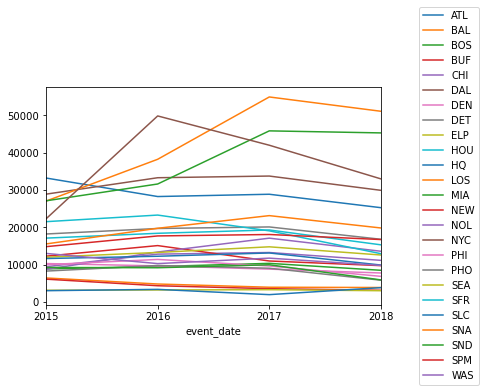

In [19]:
# create plot of the subset by FY
encounters_by_fy.plot().legend(loc='center left',bbox_to_anchor=(1.1, 0.5))

# create plot of the subset by FY
encounters_by_fy.T.sort_values(by=["2018-10-01 00:00:00"], 
                               ascending=False).style.format("{:,.0f}")

# Landmarks

In [ ]:
# create series of how many unique landmarks there are, regardless of capitalization
encounters_landmarks = encounters.landmark.str.upper().value_counts()

In [ ]:
# convert series to dataframe and print resulting table
encounters_landmarks = encounters_landmarks.to_frame()
encounters_landmarks

In [ ]:
# create subset of location variables, counting IDs
encounters_distinct_landmarks = encounters[['aor', 'landmark', 'id']].groupby(
    ['aor', 'landmark'], as_index=False, dropna=False).count()

# display all locations with at least one encounter, sorted by largest to smallest
encounters_distinct_landmarks.loc[
    encounters_distinct_landmarks['id'] > 0].sort_values('id', ascending=False)

In [ ]:
# create a historgram of encounter landmarks in groups of 100
encounters_landmarks.plot(kind='hist', bins=100)

In [ ]:
# add a column to encounters dataset that contains a binary indicator 
# of whether the landmark includes the term 'non-specific'  
encounters['non-specific'] = encounters['landmark'].str.contains(
    'non-specific', case=False, na=False).astype(int)

# create subset and calculate for each AOR 
# the number of non-specific occurences divided by the total number of encounters
# sort resulting proportions from largest to smallest
dub = encounters[['aor','id', 'non-specific']]
dub = dub.groupby('aor', dropna=False)['non-specific'].sum()/dub.groupby('aor', dropna=False)['id'].count()
dub.sort_values(ascending=False)

## Top Ten Landmarks by AOR (aggregate)

In [ ]:
# create subset of encounters by location
encounters_location = encounters.groupby(
    ['aor', 'landmark'], as_index=False, dropna=False)['id'].count()

# create a subset of the ten largest landmarks in each AOR
encounters_aor_agg = encounters_location.sort_values(
    ['aor', 'id'], ascending=False).groupby('aor', dropna=False).head(10)

# create a list of AORs in the dataset, excluding NAN
fub = set(encounters['aor'])
fub.remove(np.nan)

# function that creates a plot of the top ten largest landmarks when given an AOR
def top_landmarks_aggregate(place):
    encounters_aor_agg.loc[encounters_aor['aor'] == place].plot(
        y='id', x='landmark', kind='barh').invert_yaxis()
    plt.title(place + " " + str(encounters.loc[encounters['aor'] == place]['id'].count()))
    return

In [ ]:
# creates a plot that can select an AOR using a drop down widget
widgets.interact(top_landmarks_aggregate, place = fub)

## Top Ten Landmarks by AOR (proportions)

In [ ]:
# create new column in subset of encounters by location 
# that is the sum of all encounters in that AOR
encounters_location['aor total'] = encounters_location.groupby(
    'aor', sort=False, dropna=False)["id"].transform('sum')

# create new column in subset of encounters by location that is the 
# proportion of encounters in a landmark divided by the total encounters in that AOR
encounters_location['aor proportion'] = encounters_location['id']/encounters_location['aor total']

# create a subset of the top ten most common landmarks in each AOR
encounters_aor_prop = encounters_location.sort_values(['aor', 'id'], 
                                    ascending=False).groupby('aor', dropna=False).head(10)

# function creates a plot of the proportion of the top ten largest landmarks in a given AOR
def top_landmarks_proportion(place):
    encounters_aor_prop.loc[encounters_aor_prop['aor'] == place].plot(
        y='aor proportion', x='landmark', kind='barh').invert_yaxis()
    plt.title(place + " " + str(encounters.loc[encounters['aor'] == place]['id'].count()))
    return

In [ ]:
# creates a plot that can select an AOR using a drop down widget
widgets.interact(top_landmarks_proportion, place = fub)

# Processing Disposition

In [ ]:
# create subset of encounters with date, processing disposition and ID
encounters_by_disposition = encounters[["event_date", "processing_disposition", "id"]]

# count the number of encounters by each type of processing disposition and date
encounters_by_disposition = encounters_by_disposition.groupby(
    ["processing_disposition", "event_date"], as_index=False, dropna=False)['id'].count()

# pivot df so that index is date and columns are processing disposition 
# (allows for easy groupby in next line of code)
encounters_by_disposition = encounters_by_disposition.pivot(
    index='event_date', columns='processing_disposition', values='id')

# group by fiscal year
encounters_by_disposition = encounters_by_disposition.groupby(
    pd.Grouper(freq='AS-OCT'), dropna=False).sum()

# plot disposition types over time
encounters_by_disposition.plot().legend(loc='center left',bbox_to_anchor=(1.1, 0.5))

In [ ]:
# transpose table of transposed df to show disposition types over fiscal years
encounters_by_disposition.transpose().sort_values(
    by=["2018-10-01 00:00:00"], ascending=False).style.format("{:,.0f}")

# Citizenship

In [ ]:
# create dataframe of encounter frequency by citizenship
enc_cit = encounters.citizenship.value_counts(normalize=True).to_frame()

# renames column header
enc_cit.columns = ["encounters"]

# converts column to percent
enc_cit = enc_cit*100
enc_cit = enc_cit.round(decimals=2)
enc_cit = enc_cit.sort_values(by = ['encounters'], ascending=False)
enc_cit = enc_cit.astype(str) + '%'

# displays results
enc_cit